In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import json
import os
print("Modules imported!")

Modules imported!


In [2]:
def read_json(file_path):
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf8") as file:
            data = json.load(file)
        print(f"Data read from path: {file_path}")
        return data
    else:
        print(f"No data found at path: {file_path}")
        return {}

def serialize_json(filename, data):
    with open(filename, "w", encoding="utf8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"Data serialized to path: {filename}")

print("Functions ready!")

Functions ready!


In [3]:
# Data correction: there was a bug in the given framework causing timestamps in data_try_{n}.json to be wrong

# for workerDir in os.scandir('../Data/'):
#     data_try = read_json(workerDir.path + "/data_try_1.json")
#     for workerJson in os.scandir(workerDir.path):
#         if workerJson.name.startswith('quest') or workerJson.name.startswith('doc'):
#             sourceJson = read_json(workerJson.path)
#             if workerJson.name.startswith('quest'):
#                 data_try['timestamps_end'][0][0] = sourceJson['timestamps_end'][0]
#                 data_try['timestamps_elapsed'][0][0] = sourceJson['timestamps_elapsed']
#             else:
#                 workerJson_split = workerJson.name.split('_')
#                 docIndex = int(workerJson_split[1])
#                 docTry = int(workerJson_split[5])
#                 data_try['timestamps_end'][docIndex][docTry - 1] = sourceJson['timestamps_end'][docTry - 1]
#                 data_try['timestamps_elapsed'][docIndex][docTry - 1] = sourceJson['timestamps_elapsed']
#     serialize_json(workerDir.path + "/data_try_1.json", data_try)

In [4]:
# Worker analysis
workerInfoList = []
for workerDir in os.scandir('../Data/'):
    task_data = read_json(workerDir.path + "/task_data.json")
    data_try = read_json(workerDir.path + "/data_try_1.json")
    questionnaire = task_data['questionnaires'][0]['questions']
    reformatQuest = {}
    for question in questionnaire:
        reformatQuest[question['name']] = question['answers']
    device = task_data["worker"]['ngxDeviceDetectorProperties']["device"]
    if device == 'Unknown':
        device = task_data["worker"]['ngxDeviceDetectorProperties']["os"]
    workerInfo = {}
    for key, value in data_try['questionnaires_answers'][0].items():
        workerInfo[key] = reformatQuest[key][int(value)]
    workerInfo['device'] = device
    workerInfoList.append(workerInfo)

df = pd.DataFrame.from_dict(workerInfoList)
df

Data read from path: ../Data/VXCGS/task_data.json
Data read from path: ../Data/VXCGS/data_try_1.json
Data read from path: ../Data/AZGIQ/task_data.json
Data read from path: ../Data/AZGIQ/data_try_1.json
Data read from path: ../Data/HQWLU/task_data.json
Data read from path: ../Data/HQWLU/data_try_1.json
Data read from path: ../Data/ZLAXX/task_data.json
Data read from path: ../Data/ZLAXX/data_try_1.json
Data read from path: ../Data/UXDAQ/task_data.json
Data read from path: ../Data/UXDAQ/data_try_1.json
Data read from path: ../Data/KAHOD/task_data.json
Data read from path: ../Data/KAHOD/data_try_1.json
Data read from path: ../Data/JQJWV/task_data.json
Data read from path: ../Data/JQJWV/data_try_1.json
Data read from path: ../Data/ATCOU/task_data.json
Data read from path: ../Data/ATCOU/data_try_1.json
Data read from path: ../Data/DVRAN/task_data.json
Data read from path: ../Data/DVRAN/data_try_1.json
Data read from path: ../Data/QLZQD/task_data.json
Data read from path: ../Data/QLZQD/data_t

,Età,Lavoro,Genere letterario preferito,kindle,Importanza,Quanti libri,device
0,18-25,Studente,Formazione,No,Nulla,1-2,Android
1,46-55,Imprenditore,Rosa,No,Discreta,6-10,Android
2,18-25,Studente,Giallo,Si,Discreta,6-10,Windows
3,18-25,Studente,Giallo,Si,Discreta,1-2,Android
4,46-55,Freelancer,Formazione,Si,Discreta,3-5,Windows
5,18-25,Studente,Giallo,No,Scarsa,11+,Android
6,18-25,Studente,Fantasy,Si,Discreta,6-10,Android
7,18-25,Studente,Storiografia,No,Discreta,3-5,Android
8,46-55,Disoccupato,Giallo,No,Scarsa,1-2,Android
9,18-25,Studente,Biografia,No,Scarsa,1-2,iPhone


In [ ]:
sunburst_df = df.copy()
sunburst_df["kindle"] = sunburst_df["kindle"].apply({'Si': 'Ha un<br>eReader', 'No': 'Non ha un<br>eReader'}.get)
sunburst_device = px.sunburst(sunburst_df, path=['Età', 'Lavoro', 'device', 'kindle'])
sunburst_device.show()
force = True
if not os.path.isfile('./plot/sunburst_device.html') or force:
    sunburst_device.write_html('./plot/sunburst_device.html')
    sunburst_device.write_image('./plot/sunburst_device.png')
sunburst_genre = px.sunburst(sunburst_df, path=['Età', 'Lavoro', 'Genere letterario preferito'])
sunburst_genre.show()
force = True
if not os.path.isfile('./plot/sunburst_genre.html') or force:
    sunburst_device.write_html('./plot/sunburst_genre.html')
    sunburst_device.write_image('./plot/sunburst_genre.png')


<BarContainer object of 13 artists>

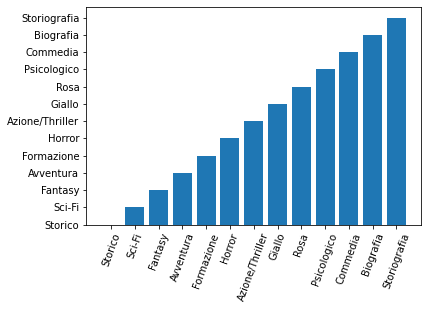

In [9]:
# -- ABSOLUTE AND RELATIVE FOR ALL QUEST PARAMETERS IN JSON -- 

# Count occourences
counter = {key:dict(Counter(df[key])) for key in df}

reformatQuestCount = {}
reformatQuestCountRel = {}

# Absolute frequencies for each option of each parameter
for key, value in reformatQuest.items():
    reformatQuestCount[key] = {label:counter[key].get(label, 0) for label in value}
    
# Relative frequencies for each option of each parameter 
for key, value in reformatQuestCount.items():
    total = sum(value.values())
    if total != 0:
        reformatQuestCountRel[key] = {label:counter[key].get(label, 0)/total for label in value.keys()}
    else:
        reformatQuestCountRel[key] = {label:0 for label in value.keys()}

# You can call this functions to save counts in json format on the current path
def serialize_count():
    serialize_json("./quest_count.json", reformatQuestCount)
    serialize_json("./quest_count_rel.json", reformatQuestCount)
    
            
# Eventually builds dataframe from json (according to the given parameter)        
def to_dataframe(param, rel=None):
    if not rel:
        return pd.DataFrame({param: reformatQuestCount[param].keys(),
                             'Frequenza': reformatQuestCount[param].values()})
    else:
        return pd.DataFrame({param: reformatQuestCountRel[param].keys(),
                             'Frequenza': reformatQuestCountRel[param].values()})

# Debugging test
# genre = to_dataframe("Genere letterario preferito")
# plt.xticks(rotation=70)
# plt.bar(genre["Genere letterario preferito"], genre["Genere letterario preferito"])
    

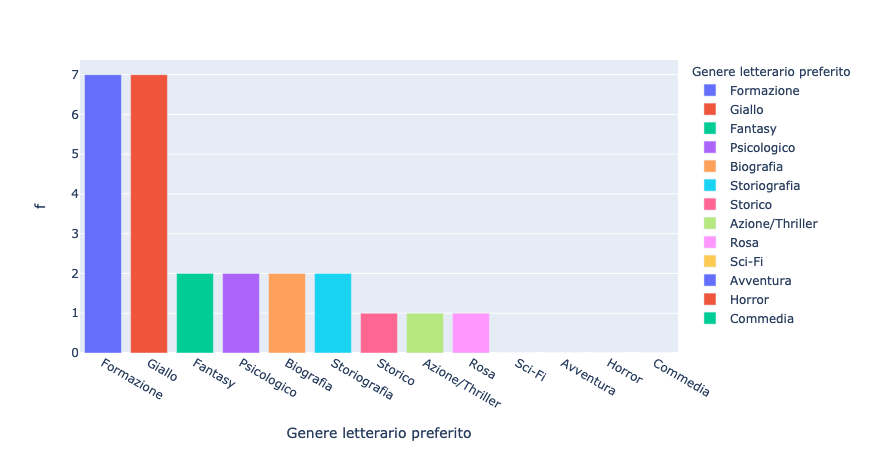

In [10]:
# Convert the genre list into a df
df_genre = pd.DataFrame(reformatQuest['Genere letterario preferito'], columns=['Genere letterario preferito'])

# Count occurrences, transform in a df and rename
counts = df['Genere letterario preferito']\
    .value_counts()\
    .to_frame()\
    .rename(columns={'Genere letterario preferito': 'f'})

# Join the previous two, replace NaN with 0s and sort everything for better view
df_genre = df_genre\
    .join(counts, on='Genere letterario preferito')\
    .replace(np.NaN, 0)\
    .sort_values(by='f', ascending=False)

# From float to int
df_genre['f'] = df_genre['f'].astype(int)

# Plot everything
bar_genre = px.bar(df_genre, x = 'Genere letterario preferito', y = 'f', color='Genere letterario preferito')
bar_genre.show()
force = False
if not os.path.isfile('./plot/bar_genre.html') or force:
    bar_genre.write_html('./plot/bar_genre.html')
    bar_genre.write_image('./plot/bar_genre.png')

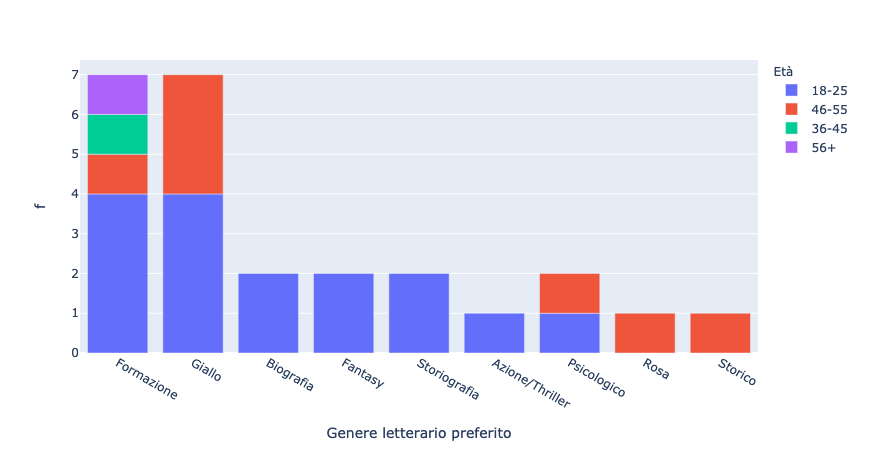

In [11]:
# Plot based on genre and age
df_genre_age = df\
    .groupby(by=['Genere letterario preferito', 'Età'])\
    .count()[['Lavoro']]\
    .rename(columns={'Lavoro': 'f'})\
    .reset_index()\
    .sort_values(by=['f'], ascending=False)

bar_genre_age = px.bar(df_genre_age, x = 'Genere letterario preferito', y = 'f', color='Età')
bar_genre_age.show()
force = False
if not os.path.isfile('./plot/bar_genre_age.html') or force:
    bar_genre_age.write_html('./plot/bar_genre_age.html')
    bar_genre_age.write_image('./plot/bar_genre_age.png')